In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import seaborn as sns
import glob 
import sys
import os
import torch

%matplotlib inline
sns.set(style="whitegrid")

### E2E - GPT-2 Large

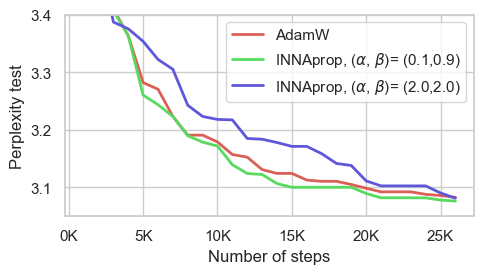

In [2]:
path = 'gpt2.lg/'
all_files = glob.glob(path + '/*/*.csv')
 
# Initialisation d'un DataFrame vide pour accumuler toutes les données
df = pd.DataFrame()
 
# Identifiant unique pour chaque run (fichier)
run_id = 0
 
for file_path in all_files:
    # Lecture du fichier CSV
    df_current = pd.read_csv(file_path)
   
    # Incrémentation de run_id pour chaque nouveau fichier
    df_current['run_id'] = run_id
    run_id += 1
   
    # Concaténation du DataFrame actuel avec le DataFrame global accumulé
    df = pd.concat([df, df_current], ignore_index=True)
   
# Prétraitement pour obtenir la moyenne des métriques par étape d'entraînement pour chaque optimiseur
df = df.groupby(['optimizer', 'train_step']).mean().reset_index()
df.sort_values(by=['optimizer', 'train_step'], inplace=True)
 
# Calcul de la meilleure perplexité de validation cumulée pour chaque optimiseur
df['best_val_ppl'] = df.groupby('optimizer')['best_val_ppl'].cummin()
 
# Valeurs sélectionnées pour les optimiseurs
selected_values = ['AdamW',
                    'INNAprop, ($\\alpha$, $\\beta$)= (0.1,0.9)',
                   'INNAprop, ($\\alpha$, $\\beta$)= (2.0,2.0)'
                  ]
# Définition de la palette de couleurs et des marqueurs
palette = sns.color_palette("hls", len(selected_values))
markers = {'AdamW': 'o',
           'INNAprop, ($\\alpha$, $\\beta$)= (0.1,0.9)': 's',
           'INNAprop, ($\\alpha$, $\\beta$)= (2.0,2.0)': 'd'
          }
 
# Création de la figure et des axes pour le plot
fig, ax = plt.subplots(figsize=(5, 3))
 
# Réglages spécifiques pour la métrique de perplexité test
metric = 'best_val_ppl'
ylim = (3.05, 3.4)  # Limite pour l'axe des Y si nécessaire
 
# Itération sur chaque optimiseur pour le plot
for optimizer in selected_values:
    subset = df[df['optimizer'] == optimizer]
   
    # Trace la ligne moyenne pour chaque optimiseur
    sns.lineplot(data=subset, x='train_step', y=metric, ax=ax, label=optimizer,
                 color=palette[selected_values.index(optimizer)], markersize=5, linewidth=2)
   
# Réglages d'échelle et limites pour l'axe des Y
if ylim:
    ax.set_ylim(ylim)
 
# Réglages des labels
ax.set_xlabel('Number of steps')
ax.set_ylabel('Perplexity test')
 
# Formatter pour l'axe des X pour montrer 'K' pour mille
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000)}K'))
 
# Légende personnalisée à l'extérieur du plot
 
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Ajustement pour accommoder la légende
plt.savefig('e2e_gpt_lg.pdf', bbox_inches='tight')
plt.show()